# 연습 데이터셋 제작하기

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
import matplotlib.pyplot as plt


### GPU 설정

In [ ]:
# ---------------------
# 1. Device 설정 (GPU 사용 가능 여부 확인)
# ---------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ---------------------
# 2. 하이퍼파라미터 설정
# ---------------------
batch_size = 32
learning_rate = 1e-3
num_epochs = 5


Using device: cpu


### 데이터셋 정의하기

In [ ]:
# ---------------------
# 3. 데이터셋 (MNIST) 로드 및 전처리
# ---------------------
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)


In [ ]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

### 데이터 라벨 재 설정

In [ ]:
train_dataset.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [ ]:
train_dataset.targets == 0

tensor([False,  True, False,  ..., False, False, False])

In [ ]:
(train_dataset.targets == 0).long()

tensor([0, 1, 0,  ..., 0, 0, 0])

In [ ]:
# ---------------------
# 4. 지금부터 숫자 0 이미지의 정답 데이터를 '이상'으로 간주해 label을 1로 둔다.
# 나머지 숫자 1~9 이미지의 정답 데이터는 '정상'으로 간주해 label을 0으로 둔다.
# ---------------------
train_targets = (train_dataset.targets == 0).long()
test_targets = (test_dataset.targets == 0).long()

train_dataset.targets = train_targets
test_dataset.targets = test_targets


In [ ]:
test_dataset.targets[:100]

tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])

In [ ]:
torch.bincount(train_targets)

tensor([54077,  5923])

### 데이터 불균형 확인하기

In [ ]:
# ---------------------
# 5. 데이터 갯수 불균형 처리
# ---------------------
# 클래스별 샘플 개수 계산
class_counts = torch.bincount(train_targets)

# 클래스 가중치(inverse frequency) 계산
# class_weights = 1.0 / class_counts.float()
# 클래스별 샘플 개수가 많을수록 가중치는 작게, 적을수록 크게 부여하기 위해

# 단순히 “샘플 개수의 역수”를 계산합니다.
# 예를 들어, 정상(1) 샘플이 8,000개, 이상(0) 샘플이 2,000개라면
# EX) class_weights = [1/2000, 1/8000] ≈ [0.0005, 0.000125]
# 즉, 소수 클래스(이상)에 더 큰 가중치를 주게 됩니다.

class_weights = 1.0 / class_counts.float() # Loss 함수를 구현할 때 활용합니다.

In [ ]:
class_weights

tensor([1.8492e-05, 1.6883e-04])

In [ ]:
# 샘플마다의 가중치 설정
sample_weights = class_weights[train_targets]
print("sample_weights: ",sample_weights.numpy(), "num_samples: ", len(sample_weights))

sample_weights:  [1.8492150e-05 1.6883336e-04 1.8492150e-05 ... 1.8492150e-05 1.8492150e-05
 1.8492150e-05] num_samples:  60000


In [ ]:
# WeightedRandomSampler 생성
# 가중치가 큰 (소수 클래스) 샘플은 더 자주, 가중치가 작은 (다수 클래스) 샘플은 덜 자주 추출됩니다.
sampler = WeightedRandomSampler(weights=sample_weights,
                                num_samples=len(sample_weights),
                                # 매 추출마다 “다시 넣기” 방식을 적용해, 동일 샘플이 여러 번 뽑힐 수 있음
                                replacement=True)


In [ ]:
# DataLoader 생성 (WeightedRandomSampler 사용)
train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    sampler=sampler
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)


In [ ]:
for data, label in train_loader:
    print(data.shape, label)
    break

torch.Size([8, 1, 28, 28]) tensor([1, 0, 1, 0, 1, 0, 0, 1])


### 데이터 분포 확인하기

Test set label distribution:
  Normal (0): 9020 samples
  Anomaly (1): 980 samples


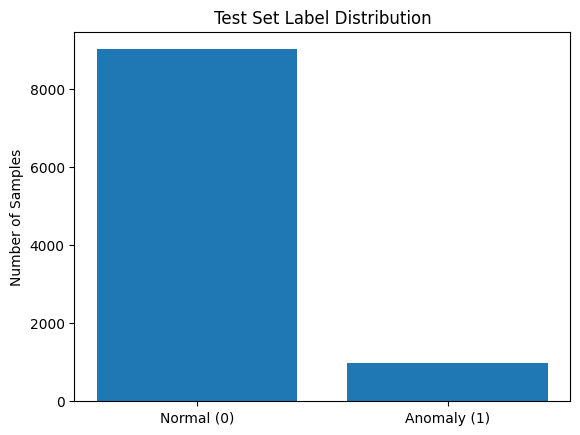

In [ ]:
# 1) 레이블 텐서 확보
# MNIST anomaly: targets 텐서에 0=normal, 1=anomaly
label_tensor = test_dataset.targets.to(device)
label_names = ['Normal (0)', 'Anomaly (1)']

# 2) 클래스별 샘플 개수 계산
counts = torch.bincount(label_tensor)

# 3) 콘솔에 분포 출력
print("Test set label distribution:")
for name, cnt in zip(label_names, counts.tolist()):
    print(f"  {name}: {cnt} samples")

# 4) 막대그래프로 시각화
plt.figure()
plt.bar(label_names, counts.cpu().tolist())
plt.title('Test Set Label Distribution')
plt.ylabel('Number of Samples')
plt.show()
